In [2]:
import src
import numpy as np
import torch
from torchvision.transforms import Compose, Lambda, ToPILImage, Resize, ToTensor, CenterCrop
from PIL import Image
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
beta_start = 0.0001
beta_end = 0.02
timesteps = 300
image_size = 32
num_channels = 3
batch_size = 128
dataset_name = 'cifar10'
results_folder_name = './results'
sample_and_save_freq = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
learninig_rate = 1e-3
epochs = 50

In [4]:
# create line plot
def plot_line(x, y, x_label, y_label):
    plt.clf()
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


t_range = [t for t in range(0, timesteps)]

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image_size = 128

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])


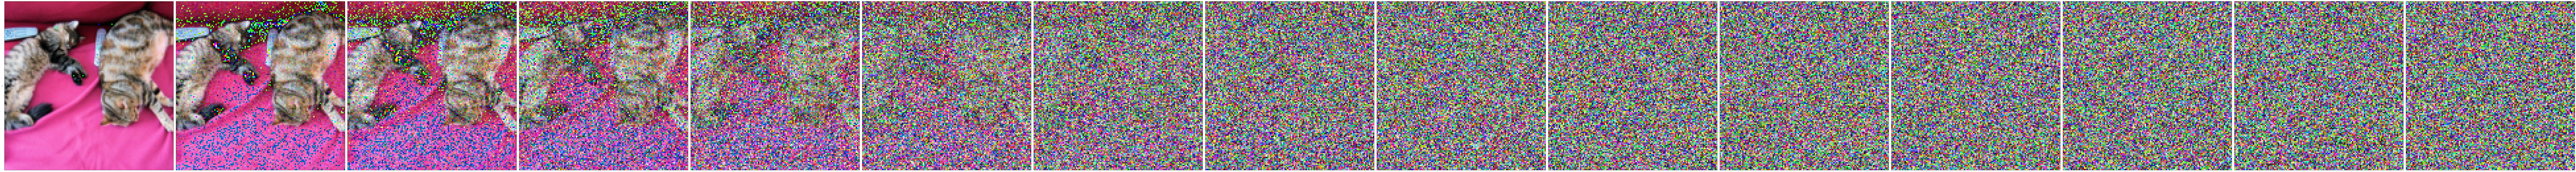

In [16]:
scheduler = src.LinearScheduler(beta_start=beta_start, beta_end=beta_end, timesteps=timesteps)
forward_diffusion = src.ForwardDiffusion(sqrt_alphas_cumprod=scheduler.sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=scheduler.sqrt_one_minus_alphas_cumprod, reverse_transform=reverse_transform)
# plot_line(t_range, scheduler.betas, 't', 'y(t)')
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
linear_imgs = [forward_diffusion.get_noisy_image(x_start=x_start, t=torch.tensor([t])) for t in range(0, timesteps, timesteps // 15)]
src.plot(image=image, imgs=linear_imgs, row_title="Linear")

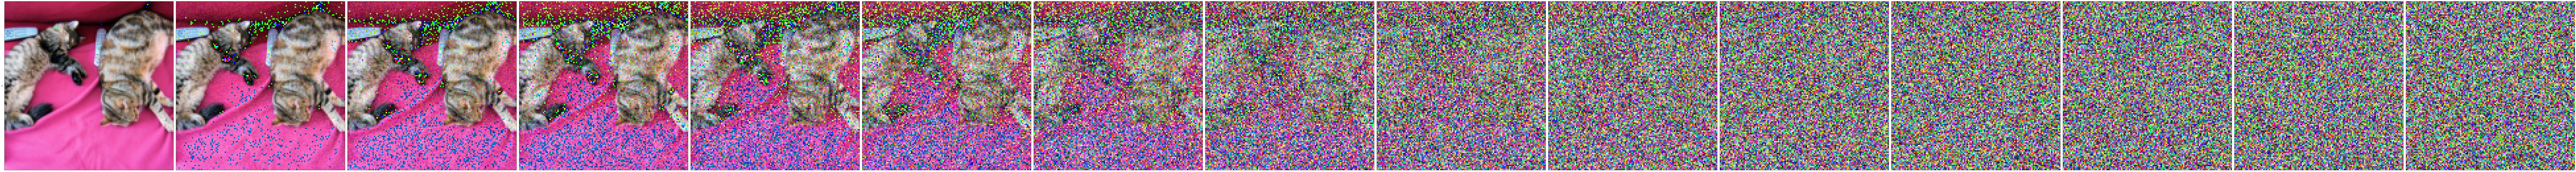

In [17]:
scheduler = src.QuadraticScheduler(beta_start=beta_start, beta_end=beta_end, timesteps=timesteps)
forward_diffusion = src.ForwardDiffusion(sqrt_alphas_cumprod=scheduler.sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=scheduler.sqrt_one_minus_alphas_cumprod, reverse_transform=reverse_transform)
# plot_line(t_range, scheduler.betas, 't', 'y(t)')
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
quadratic_imgs = [forward_diffusion.get_noisy_image(x_start=x_start, t=torch.tensor([t])) for t in range(0, timesteps, timesteps // 15)]
src.plot(image=image, imgs=quadratic_imgs, row_title="Quadratic")

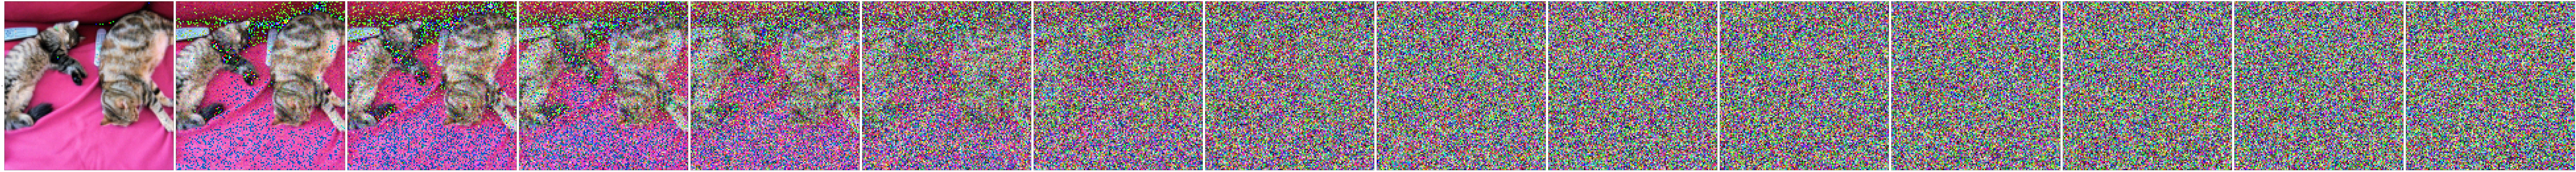

In [18]:
scheduler = src.CosineScheduler(beta_start=beta_start, beta_end=beta_end, timesteps=timesteps)
forward_diffusion = src.ForwardDiffusion(sqrt_alphas_cumprod=scheduler.sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=scheduler.sqrt_one_minus_alphas_cumprod, reverse_transform=reverse_transform)
# plot_line(t_range, scheduler.betas, 't', 'y(t)')
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
cosine_imgs = [forward_diffusion.get_noisy_image(x_start=x_start, t=torch.tensor([t])) for t in range(0, timesteps, timesteps // 15)]
src.plot(image=image, imgs=cosine_imgs, row_title="Cosine")


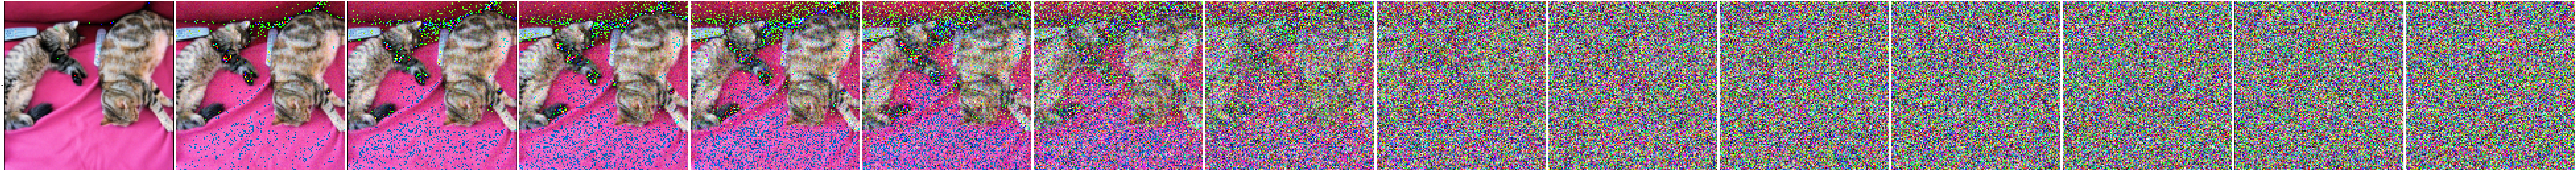

In [19]:
scheduler = src.SigmoidScheduler(beta_start=beta_start, beta_end=beta_end, timesteps=timesteps)
forward_diffusion = src.ForwardDiffusion(sqrt_alphas_cumprod=scheduler.sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=scheduler.sqrt_one_minus_alphas_cumprod, reverse_transform=reverse_transform)
# plot_line(t_range, scheduler.betas, 't', 'y(t)')
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
sigmoid_imgs = [forward_diffusion.get_noisy_image(x_start=x_start, t=torch.tensor([t])) for t in range(0, timesteps, timesteps // 15)]
src.plot(image=image, imgs=sigmoid_imgs, row_title="Sigmoid")



In [68]:
# resize the original image to 128x128
image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((128, 128))
# add this image to the all images lists
linear_imgs = [image] + linear_imgs
quadratic_imgs = [image] + quadratic_imgs
cosine_imgs = [image] + cosine_imgs
sigmoid_imgs = [image] + sigmoid_imgs


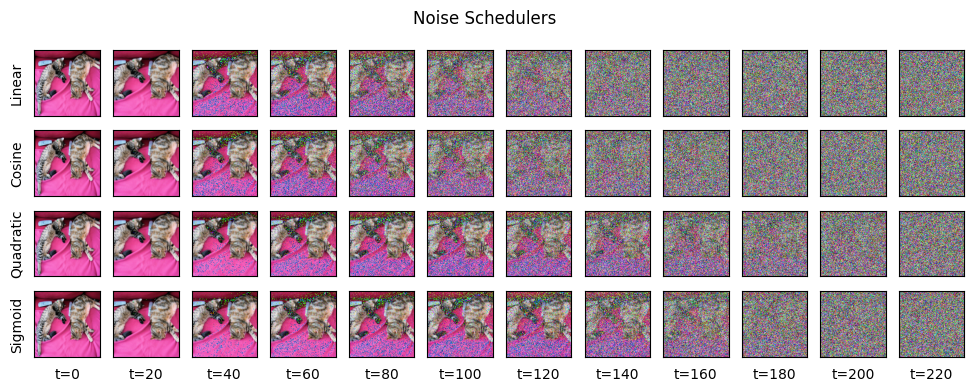

In [76]:
# Create a figure with 4 subplots
# each subplot is a row of images corresponding to a different scheduler
# Each row starts with a label titled with the scheduler name
# linear first
# cosine second
# quadratic third
# sigmoid fourth
# each row has 15 images
# the first row should have the timesteps on top of the images and the last row should have the timesteps on the bottom of the images (the other rows should not have timesteps)
# the first column should have the scheduler name on the left of the images horizontally (the other columns should not have the scheduler name)
# 0 padding
fig, axs = plt.subplots(4, 12, figsize=(12, 4), sharex=True, sharey=True, constrained_layout=False)
fig.suptitle('Noise Schedulers')
scheduler_names = ['Linear', 'Cosine', 'Quadratic', 'Sigmoid']
timesteps_labels = [t for t in range(0, timesteps + 1, timesteps // 15)][:12]
linear_imgs = linear_imgs[:12]
quadratic_imgs = quadratic_imgs[:12]
cosine_imgs = cosine_imgs[:12]
sigmoid_imgs = sigmoid_imgs[:12]

# turn off the axis ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

for i, scheduler in enumerate([linear_imgs, cosine_imgs, quadratic_imgs, sigmoid_imgs]):
    for j, img in enumerate(scheduler):
        axs[i, j].imshow(img)
        if i == 3:
            axs[i, j].set_xlabel(f't={timesteps_labels[j]}')
        if j == 0:
            axs[i, j].set_ylabel(f'{scheduler_names[i]}', rotation=90, size='medium')





# Save the figure
fig.savefig('noise_schedulers.png', bbox_inches='tight')